# Sentiment analiza objava Donalda J. Trumpa i povezanost s volatilnošću tržišta

## Sažetak
Cilj projekta je integrirati heterogene izvore podataka o objavama Donalda J. Trumpa (društvene mreže) i tržišnim indikatorima volatilnosti te provesti bazičnu analitiku: sentiment, korelacije s vremenskim pomakom, klasteriranje (K-means) i demonstraciju pristupa podacima kroz REST API. Projekt je organiziran kao reproducibilna Jupyter bilježnica s ugrađenom dokumentacijom i referencama u IEEE stilu.

## Korišteni skupovi podataka
- Skup A (CSV): objave s društvenih mreža (Twitter/X i Truth Social) preuzete iz Kaggle skupa podataka [1].
- Skup B (JSON): tržišni podaci (VIX i SPY) dohvaćeni putem javno dostupnog Yahoo Finance sučelja kroz biblioteku `yfinance`, pohranjeni kao JSON radi heterogenosti formata [2].

## Napomena o umjetnoj inteligenciji
U izradi projekta korišten je generativni alat za pomoć pri dizajnu pipelinea i ispravljanju implementacijskih grešaka. U dokumentaciju je potrebno dodati poveznicu ili presliku relevantnih konverzacija s vidljivim promptovima i odgovorima, u skladu s pravilima kolegija.

U praktičnom smislu, ovaj rad spaja dva svijeta: tekstualne objave (koje su nestrukturirane i često kontekstualno ovisne) te numeričke tržišne serije (koje su strukturirane, ali podložne snažnim vanjskim šokovima). Naglasak je na reproducibilnom tijeku rada: od učitavanja i čišćenja podataka, preko stvaranja značajki i agregacije, do modeliranja i prezentacije rezultata. Posebno je važno naglasiti da se ovdje promatraju obrasci i asocijacije (deskriptivna analitika), a ne uzročni učinci.

U nastavku se koriste jednostavne, transparentne metode (VADER sentiment, korelacijske analize s vremenskim pomakom, linearni model s kontrolom autokorelacije i K-means). Takav odabir omogućuje jasno objašnjenje koraka i lakšu provjeru rezultata, uz svjesno prihvaćanje ograničenja ovih pristupa. Interpretaciju treba raditi oprezno, uz pretpostavku da makroekonomske vijesti, regulatorne promjene i geopolitički događaji mogu istodobno utjecati i na tržište i na ton komunikacije.


## 1. Okruženje i ovisnosti

U nastavku se instaliraju i uvoze biblioteke korištene u projektu. Radi reproduktivnosti, preporučuje se pokretanje ćelija redom.

Kako bi rezultati bili usporedivi pri ponovnom pokretanju, preporučuje se zapisati verzije ključnih biblioteka (npr. `pandas`, `numpy`, `scikit-learn`, `statsmodels`, `yfinance`) te po mogućnosti koristiti izolirano okruženje (virtualenv/conda). Ako se notebook pokreće u Colabu, korisno je na početku zabilježiti verziju Pythona i tip runtime-a. Kod algoritama koji uključuju slučajnost (npr. K-means) dobro je postaviti `random_state` kako bi klasteri bili stabilni.

U slučaju problema s instalacijom (npr. ograničenja mreže ili promjene ovisnosti), alternativa je korištenje `requirements.txt` ili `pip freeze` ispisa, čime se osigurava konzistentno okruženje i manji rizik da se rezultati razlikuju zbog verzija paketa.


In [ ]:
!pip -q install pandas numpy matplotlib scikit-learn nltk yfinance fastapi uvicorn nest_asyncio requests statsmodels scipy

In [ ]:
import os
import json
import sqlite3
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [ ]:
import nltk
nltk.download("vader_lexicon")
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
import yfinance as yf

In [ ]:
import statsmodels.api as sm
from scipy import stats

## 2. Prikupljanje i učitavanje podataka

### 2.1. Skup A (CSV): objave s društvenih mreža
Učitavaju se dvije CSV datoteke:
- `tweets.csv` (Twitter/X objave i metapodaci)
- `djt_posts_dec2025.csv` (Truth Social objave i metapodaci)

Datoteke su dio šireg Kaggle skupa podataka koji objedinjuje Trumpove objave do prosinca 2025. [1].

Ako radite u Colab okruženju, putanje prilagodite lokaciji datoteka u `/content`. U ovom primjeru koristi se putanja u radnom direktoriju bilježnice.

Kod rada s podacima s društvenih mreža važno je imati na umu nekoliko tipičnih izvora pristranosti: promjene platforme kroz vrijeme, nedostupne ili obrisane objave, duplikati (repostovi/retweetovi), te razlike u poljima metapodataka između izvora. Osim toga, tekst može sadržavati URL-ove, oznake korisnika, hashtagove i posebne znakove koji mogu utjecati na sentiment modele.

Prije daljnje analize preporučuje se provjeriti vremenski raspon (min/max datum), udio nedostajućih vrijednosti, te osnovne statistike duljine teksta. Time se ranije uočavaju anomalije (npr. neuobičajeno kratke ili prazne objave) i smanjuje rizik da kasnije korake vode pogrešni ulazi.


In [ ]:
put_twitter = "tweets.csv"
put_truth = "djt_posts_dec2025.csv"

df_twitter_raw = pd.read_csv(put_twitter)
df_truth_raw = pd.read_csv(put_truth)

(df_twitter_raw.shape, df_truth_raw.shape)

((56571, 9), (90343, 18))

In [ ]:
df_twitter_raw.head(3)

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f


In [ ]:
df_truth_raw.head(3)

,id,date,platform,handle,text,favorite_count,repost_count,quote_flag,repost_flag,deleted_flag,word_count,hashtags,urls,user_mentions,media_count,media_urls,post_url,in_reply_to
0,115816402893182666,2025-12-31 21:54:21+00:00,Truth Social,realDonaldTrump,"Good News! George and Amal Clooney, two of the...",52,16,False,False,False,144,NaN,NaN,NaN,0,NaN,https://truthsocial.com/@realDonaldTrump/posts...,NaN
1,115816171466225987,2025-12-31 20:55:30+00:00,Truth Social,realDonaldTrump,We are removing the National Guard from Chicag...,44,16,False,False,False,107,NaN,NaN,NaN,0,NaN,https://truthsocial.com/@realDonaldTrump/posts...,NaN
2,115816098525451632,2025-12-31 20:36:57+00:00,Truth Social,realDonaldTrump,The Democrats are a bunch of cheaters and thie...,461,179,False,False,False,50,NaN,NaN,NaN,0,NaN,https://truthsocial.com/@realDonaldTrump/posts...,NaN


## 3. Pretprocesiranje i integracija podataka

### 3.1. Normalizacija sheme
Cilj je mapirati oba izvora na zajedničku shemu:

- `id`, `datum_utc`, `platforma`, `handle`, `tekst`
- `broj_lajkova`, `broj_repostova`, `je_repost`, `je_obrisano`
- pomoćne značajke: broj riječi, broj znakova, broj uskličnika, udio velikih slova

Time dobivamo jedinstvenu tablicu objava neovisno o izvoru.

Pretprocesiranje je ključan korak jer različiti izvori često imaju istu semantiku, ali drugačiju strukturu. Normalizacijom sheme osigurava se da se svaka objava može analizirati na isti način (neovisno o platformi), što pojednostavljuje agregacije, vizualizacije i izradu modela.

U ovoj fazi tipično se rješavaju i praktični problemi: vremenske zone i format datuma, uklanjanje očitih duplikata, standardizacija tekstnih polja (npr. pretvorba u `str`, uklanjanje višestrukih razmaka), te dosljedno imenovanje stupaca. Dobra praksa je na kraju pretprocesiranja napraviti nekoliko provjera konzistentnosti (broj redaka, jedinstvenost ključeva, validni rasponi numeričkih polja) kako bi se izbjegli tihi problemi u kasnijim analizama.


In [ ]:
df_twitter = df_twitter_raw.copy()
df_twitter["platforma"] = "Twitter"
df_twitter["handle"] = "realDonaldTrump"
df_twitter["datum_utc"] = pd.to_datetime(df_twitter["date"], errors="coerce", utc=True)
df_twitter["tekst"] = df_twitter["text"].astype(str)

df_twitter["broj_lajkova"] = pd.to_numeric(df_twitter["favorites"], errors="coerce")
df_twitter["broj_repostova"] = pd.to_numeric(df_twitter["retweets"], errors="coerce")

df_twitter["je_repost"] = df_twitter["isRetweet"].astype(str).str.lower().eq("t")
df_twitter["je_obrisano"] = df_twitter["isDeleted"].astype(str).str.lower().eq("t")

df_twitter = df_twitter[["id","datum_utc","platforma","handle","tekst","broj_lajkova","broj_repostova","je_repost","je_obrisano"]].copy()
df_twitter = df_twitter.dropna(subset=["datum_utc","tekst"])

In [ ]:
df_truth = df_truth_raw.copy()
df_truth["platforma"] = df_truth["platform"].astype(str)
df_truth["handle"] = df_truth["handle"].astype(str)
df_truth["datum_utc"] = pd.to_datetime(df_truth["date"], errors="coerce", utc=True)
df_truth["tekst"] = df_truth["text"].astype(str)

df_truth["broj_lajkova"] = pd.to_numeric(df_truth["favorite_count"], errors="coerce")
df_truth["broj_repostova"] = pd.to_numeric(df_truth["repost_count"], errors="coerce")

df_truth["je_repost"] = pd.to_numeric(df_truth.get("repost_flag", False), errors="coerce").fillna(False).astype(bool)
df_truth["je_obrisano"] = pd.to_numeric(df_truth.get("deleted_flag", False), errors="coerce").fillna(False).astype(bool)

df_truth = df_truth[["id","datum_utc","platforma","handle","tekst","broj_lajkova","broj_repostova","je_repost","je_obrisano"]].copy()
df_truth = df_truth.dropna(subset=["datum_utc","tekst"])

In [ ]:
objave = pd.concat([df_twitter, df_truth], ignore_index=True)
objave["id"] = objave["id"].astype(str)
objave = objave.drop_duplicates(subset=["id"], keep="first")

objave["broj_lajkova"] = objave["broj_lajkova"].fillna(0).astype(float)
objave["broj_repostova"] = objave["broj_repostova"].fillna(0).astype(float)

objave = objave[objave["je_obrisano"].fillna(False) == False].copy()
objave = objave[objave["tekst"].astype(str).str.strip().ne("")].copy()

objave.shape

(87983, 9)

### 3.2. Inženjering tekstualnih značajki
U nastavku se izračunavaju jednostavne značajke nad tekstom, korisne za EDA i K-means.

Tekstualne značajke (npr. broj riječi, uskličnici, udio velikih slova) služe kao jednostavne, interpretabilne mjere stila komunikacije. Iako ne hvataju semantiku u dubini, često su korisne za EDA (npr. uočavanje dana s "agresivnijim" tonom) i za grupiranje dana u režime.

Važno je da se značajke računaju konzistentno: istim pravilima tokenizacije i istim tretmanom nedostajućih tekstova. Ako se u tekstu nalaze linkovi ili oznake korisnika, moguće je razmotriti njihovo uklanjanje prije brojanja riječi, kako bi mjere više odražavale sadržaj, a manje tehničke artefakte platforme.


In [ ]:
def udio_velikih_slova(s):
    s = str(s)
    slova = [c for c in s if c.isalpha()]
    if len(slova) == 0:
        return 0.0
    velika = [c for c in slova if c.isupper()]
    return len(velika) / len(slova)

objave["broj_znakova"] = objave["tekst"].astype(str).str.len().astype(int)
objave["broj_rijeci"] = objave["tekst"].astype(str).str.split().apply(len).astype(int)
objave["broj_usklicnika"] = objave["tekst"].astype(str).str.count("!").astype(int)
objave["udio_velikih"] = objave["tekst"].apply(udio_velikih_slova).astype(float)
objave["angazman"] = np.log1p(objave["broj_lajkova"] + objave["broj_repostova"])

objave[["platforma","datum_utc","broj_rijeci","angazman"]].head()

,platforma,datum_utc,broj_rijeci,angazman
0,Twitter,2011-08-02 18:07:48+00:00,9,5.720312
1,Twitter,2020-03-03 01:34:50+00:00,43,11.420295
2,Twitter,2020-01-17 03:22:47+00:00,21,8.908830
3,Twitter,2020-09-12 20:10:58+00:00,49,11.552435
4,Twitter,2020-01-17 13:13:59+00:00,22,9.114050


## 4. Sentiment analiza (VADER)

Za sentiment se koristi VADER, pravilan model prilagođen kratkim objavama na društvenim mrežama [3]. Računa se `compound` vrijednost u rasponu [-1, 1].

VADER je leksički (rule-based) pristup koji dobro radi na kratkim, neformalnim tekstovima jer uključuje pravila za pojačivače (npr. "very"), negacije, upotrebu velikih slova, interpunkciju i emotikone. U ovoj bilježnici fokus je na `compound` skoru jer sažima ukupni polaritet u jednu vrijednost.

Prilikom interpretacije korisno je provjeriti nekoliko ručnih primjera (objave s najvišim i najnižim skorom) kako bi se vidjelo odgovara li skor intuiciji. Politički diskurs, ironija i specifični izrazi mogu biti izvor grešaka, pa rezultati sentimenta trebaju biti shvaćeni kao aproksimacija, a ne kao "istina" o emocionalnom tonu.


In [ ]:
def vader_compound(t):
    return sia.polarity_scores(str(t))["compound"]

objave["sentiment"] = objave["tekst"].apply(vader_compound).astype(float)
objave[["datum_utc","platforma","sentiment","tekst"]].head(3)

,datum_utc,platforma,sentiment,tekst
0,2011-08-02 18:07:48+00:00,Twitter,-0.1779,Republicans and Democrats have both created ou...
1,2020-03-03 01:34:50+00:00,Twitter,0.9792,I was thrilled to be back in the Great city of...
2,2020-01-17 03:22:47+00:00,Twitter,0.0000,RT @CBS_Herridge: READ: Letter to surveillance...


## 5. Agregacija po trgovačkom danu (New York)

Tržišta su vezana uz američku trgovačku sesiju. Datumi se prevode u `America/New_York` te se objave nakon 16:00 (NY) pripisuju sljedećem trgovačkom danu radi poravnanja s reakcijom tržišta.

Poravnanje objava s trgovačkim danom je praktično zato što tržišni indikatori (npr. VIX) imaju jasnu definiciju dnevne vrijednosti vezanu uz burzovnu sesiju. Objave nakon zatvaranja tržišta mogu utjecati na sentiment investitora i reakciju tek sljedećeg dana, pa je atribucija nakon 16:00 na sljedeći trgovački dan razuman kompromis.

U praksi treba voditi računa i o neradnim danima (vikendi i praznici). Ako se objave javljaju vikendom, one se u tržišnim serijama najčešće "preslikavaju" na prvi sljedeći trgovački dan, što može uvesti dodatni šum. Zbog toga je korisno eksplicitno provjeriti koliko je dana bez tržišnih podataka i kako se ti slučajevi tretiraju u spajanju skupova.


In [ ]:
objave["datum_ny"] = objave["datum_utc"].dt.tz_convert("America/New_York")
objave["trgovacki_dan"] = objave["datum_ny"].dt.floor("D")
mask_poslije_zatvaranja = objave["datum_ny"].dt.hour >= 16
objave.loc[mask_poslije_zatvaranja, "trgovacki_dan"] = objave.loc[mask_poslije_zatvaranja, "trgovacki_dan"] + pd.Timedelta(days=1)

objave[["datum_utc","datum_ny","trgovacki_dan"]].head()

,datum_utc,datum_ny,trgovacki_dan
0,2011-08-02 18:07:48+00:00,2011-08-02 14:07:48-04:00,2011-08-02 00:00:00-04:00
1,2020-03-03 01:34:50+00:00,2020-03-02 20:34:50-05:00,2020-03-03 00:00:00-05:00
2,2020-01-17 03:22:47+00:00,2020-01-16 22:22:47-05:00,2020-01-17 00:00:00-05:00
3,2020-09-12 20:10:58+00:00,2020-09-12 16:10:58-04:00,2020-09-13 00:00:00-04:00
4,2020-01-17 13:13:59+00:00,2020-01-17 08:13:59-05:00,2020-01-17 00:00:00-05:00


In [ ]:
dnevno = (objave.groupby("trgovacki_dan")
          .agg(
              broj_objava=("sentiment","size"),
              sent_sred=("sentiment","mean"),
              sent_med=("sentiment","median"),
              sent_std=("sentiment","std"),
              ang_sred=("angazman","mean"),
              rijeci_sred=("broj_rijeci","mean"),
              usk_sred=("broj_usklicnika","mean"),
              velika_sred=("udio_velikih","mean")
          )
          .reset_index()
          .sort_values("trgovacki_dan"))

dnevno["trgovacki_dan"] = pd.to_datetime(dnevno["trgovacki_dan"]).dt.tz_localize(None)

dnevno.head()

,trgovacki_dan,broj_objava,sent_sred,sent_med,sent_std,ang_sred,rijeci_sred,usk_sred,velika_sred
0,2009-05-04,1,0.52550,0.52550,NaN,7.285507,23.0,1.0,0.106383
1,2009-05-05,1,0.77120,0.77120,NaN,5.683580,22.0,1.0,0.091743
2,2009-05-08,1,0.64680,0.64680,NaN,3.970292,17.0,1.0,0.119565
3,2009-05-09,1,0.00000,0.00000,NaN,3.713572,13.0,0.0,0.120482
4,2009-05-12,2,0.16175,0.16175,0.228749,6.010919,20.5,0.0,0.084705


## 6. Bazična analiza podataka i vizualizacije

U nastavku se prikazuju osnovne distribucije i vremenski trendovi sentimenta.

EDA (exploratory data analysis) pomaže razumjeti raspodjele i ekstremne vrijednosti prije nego što se krene u formalnije mjere. Tipično se promatraju: koliko često sentiment oscilira, postoje li razdoblja s dugotrajnim pozitivnim/negativnim tonom, te kako se volumen objava mijenja kroz vrijeme.

Kod vremenskih serija dobro je usporediti više prikaza: sirovu seriju, zaglađenu seriju (npr. rolling prosjek) te prikaz ekstremnih dana. Time se lakše prepoznaju regime shiftovi i potencijalni outlieri koji mogu dominirati korelacijama.


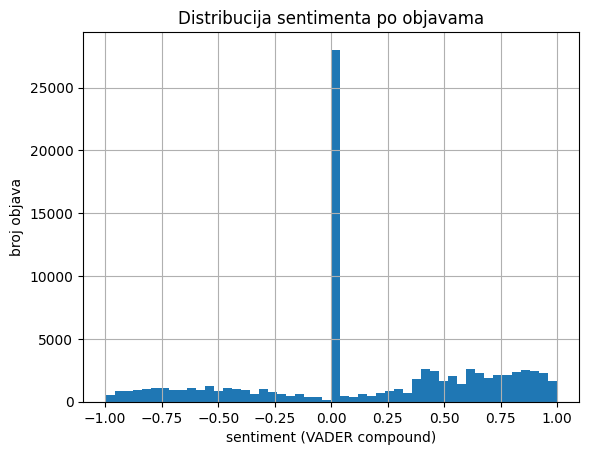

In [ ]:
plt.figure()
objave["sentiment"].hist(bins=50)
plt.xlabel("sentiment (VADER compound)")
plt.ylabel("broj objava")
plt.title("Distribucija sentimenta po objavama")
plt.show()

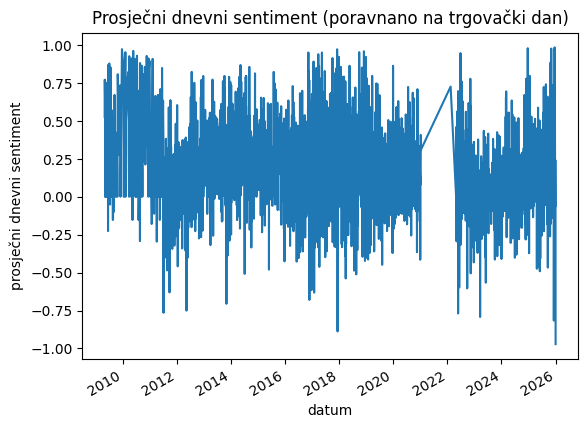

In [ ]:
plt.figure()
dnevno.set_index("trgovacki_dan")["sent_sred"].plot()
plt.xlabel("datum")
plt.ylabel("prosječni dnevni sentiment")
plt.title("Prosječni dnevni sentiment (poravnano na trgovački dan)")
plt.show()

In [ ]:
platforme = (objave.groupby("platforma")["sentiment"]
              .agg(["count","mean","median","std"])
              .sort_values("count", ascending=False))
platforme

,count,mean,median,std
platforma,,,,
Twitter,57473,0.185083,0.2003,0.516770
Truth Social,30510,0.084028,0.0000,0.494754


## 7. Skup B (JSON): prikupljanje tržišnih podataka i pohrana u JSON

Tržišni podaci dohvaćaju se preko `yfinance` (Yahoo Finance javno dostupno sučelje) [2]. Kako bi se zadovoljila heterogenost formata, dohvaćeni podaci pohranjuju se u JSON i zatim ponovno učitavaju.

Koriste se:
- `^VIX` kao aproksimacija očekivane volatilnosti tržišta
- `SPY` kao likvidni proxy za S&P 500, iz kojeg se računa realizirana volatilnost (20 dana)

Kod rada s podacima s društvenih mreža važno je imati na umu nekoliko tipičnih izvora pristranosti: promjene platforme kroz vrijeme, nedostupne ili obrisane objave, duplikati (repostovi/retweetovi), te razlike u poljima metapodataka između izvora. Osim toga, tekst može sadržavati URL-ove, oznake korisnika, hashtagove i posebne znakove koji mogu utjecati na sentiment modele.

Prije daljnje analize preporučuje se provjeriti vremenski raspon (min/max datum), udio nedostajućih vrijednosti, te osnovne statistike duljine teksta. Time se ranije uočavaju anomalije (npr. neuobičajeno kratke ili prazne objave) i smanjuje rizik da kasnije korake vode pogrešni ulazi.


In [ ]:
pocetak = dnevno["trgovacki_dan"].min().strftime("%Y-%m-%d")
kraj = (dnevno["trgovacki_dan"].max() + pd.Timedelta(days=2)).strftime("%Y-%m-%d")

vix_raw = yf.download("^VIX", start=pocetak, end=kraj, auto_adjust=True, progress=False)
spy_raw = yf.download("SPY", start=pocetak, end=kraj, auto_adjust=True, progress=False)

vix_raw.shape, spy_raw.shape

((4194, 5), (4194, 5))

In [ ]:
def normaliziraj_yf(df):
    df = df.copy()
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [c[0] for c in df.columns]
    if "Date" not in df.columns:
        df = df.reset_index()
    df = df.rename(columns={"Date":"datum"})
    df["datum"] = pd.to_datetime(df["datum"], errors="coerce")
    return df

vix = normaliziraj_yf(vix_raw)
spy = normaliziraj_yf(spy_raw)

vix.columns, spy.columns

(Index(['datum', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object'),
 Index(['datum', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object'))

In [ ]:
def odaberi_close(df):
    kandidati = ["Close","Adj Close","close","adj close","adj_close"]
    for k in kandidati:
        if k in df.columns:
            return k
    for c in df.columns:
        if "close" in str(c).lower():
            return c
    raise KeyError(str(df.columns))

vix_close = odaberi_close(vix)
spy_close = odaberi_close(spy)

(vix_close, spy_close)

('Close', 'Close')

In [ ]:
trziste = pd.DataFrame()
trziste["datum"] = pd.to_datetime(spy["datum"]).dt.tz_localize(None)

trziste["spy_close"] = pd.to_numeric(spy[spy_close], errors="coerce")
trziste["spy_ret"] = trziste["spy_close"].pct_change()
trziste["rv20"] = trziste["spy_ret"].rolling(20).std() * (252 ** 0.5)

vix2 = pd.DataFrame()
vix2["datum"] = pd.to_datetime(vix["datum"]).dt.tz_localize(None)
vix2["vix_close"] = pd.to_numeric(vix[vix_close], errors="coerce")
vix2["vix_chg"] = vix2["vix_close"].diff()

trziste = trziste.merge(vix2, on="datum", how="left").sort_values("datum")
trziste.head()

,datum,spy_close,spy_ret,rv20,vix_close,vix_chg
0,2009-05-04,67.118683,NaN,NaN,34.529999,NaN
1,2009-05-05,66.889732,-0.003411,NaN,33.360001,-1.169998
2,2009-05-06,68.049210,0.017334,NaN,32.450001,-0.910000
3,2009-05-07,67.103905,-0.013891,NaN,33.439999,0.989998
4,2009-05-08,68.669632,0.023333,NaN,32.049999,-1.389999


In [ ]:
put_json = "trziste.json"

tmp_json = trziste.copy()
tmp_json["datum"] = pd.to_datetime(tmp_json["datum"], errors="coerce").dt.strftime("%Y-%m-%d")

with open(put_json, "w", encoding="utf-8") as f:
    json.dump(tmp_json.to_dict(orient="records"), f, ensure_ascii=False)

with open(put_json, "r", encoding="utf-8") as f:
    trziste_json = json.load(f)

trziste_ucitano = pd.DataFrame(trziste_json)
trziste_ucitano["datum"] = pd.to_datetime(trziste_ucitano["datum"])
trziste_ucitano.shape


(4194, 6)

## 8. Integracija skupova A i B

Spajanje se radi na razini trgovačkog dana (`trgovacki_dan` ↔ `datum`). Dobiva se integrirani skup sa sentiment metrikama i tržišnim indikatorima.

Spajanje na razini dana pojednostavljuje analizu, ali uvodi agregacijski efekt: intradnevna dinamika se gubi, a više objava unutar jednog dana svodi se na nekoliko sažetih mjera (prosjek, standardna devijacija, broj objava). Ovaj pristup je dobar za početnu analizu i za izbjegavanje prevelike složenosti.

U ovoj fazi važno je paziti na tip spajanja (inner/left join) i na to kako se tretiraju dani bez objava ili bez tržišnih podataka. Razumna praksa je eksplicitno zabilježiti koliko je redaka izgubljeno u spajanju i zašto, jer to može utjecati na interpretaciju korelacija i regresije.


In [ ]:
integrirano = (dnevno
               .merge(trziste_ucitano, left_on="trgovacki_dan", right_on="datum", how="left")
               .drop(columns=["datum"])
               .sort_values("trgovacki_dan"))

integrirano.head(), integrirano.isna().mean()

(  trgovacki_dan  broj_objava  sent_sred  sent_med  sent_std  ang_sred  \
 0    2009-05-04            1    0.52550   0.52550       NaN  7.285507   
 1    2009-05-05            1    0.77120   0.77120       NaN  5.683580   
 2    2009-05-08            1    0.64680   0.64680       NaN  3.970292   
 3    2009-05-09            1    0.00000   0.00000       NaN  3.713572   
 4    2009-05-12            2    0.16175   0.16175  0.228749  6.010919   
 
    rijeci_sred  usk_sred  velika_sred  spy_close   spy_ret  rv20  vix_close  \
 0         23.0       1.0     0.106383  67.118683       NaN   NaN  34.529999   
 1         22.0       1.0     0.091743  66.889732 -0.003411   NaN  33.360001   
 2         17.0       1.0     0.119565  68.669632  0.023333   NaN  32.049999   
 3         13.0       0.0     0.120482        NaN       NaN   NaN        NaN   
 4         20.5       0.0     0.084705  67.185143 -0.002959   NaN  31.799999   
 
     vix_chg  
 0       NaN  
 1 -1.169998  
 2 -1.389999  
 3       NaN

<Figure size 640x480 with 0 Axes>

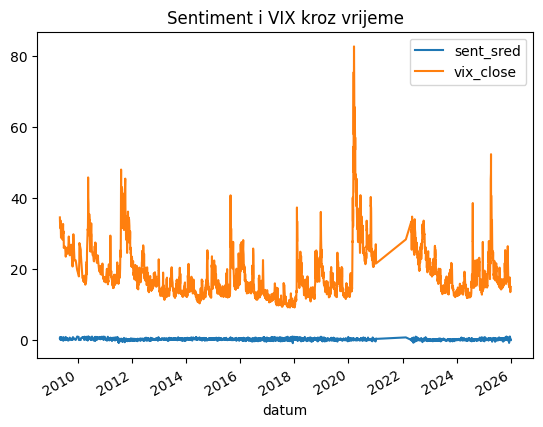

In [ ]:
plt.figure()
integrirano.set_index("trgovacki_dan")[["sent_sred","vix_close"]].dropna().plot()
plt.xlabel("datum")
plt.title("Sentiment i VIX kroz vrijeme")
plt.show()

<Figure size 640x480 with 0 Axes>

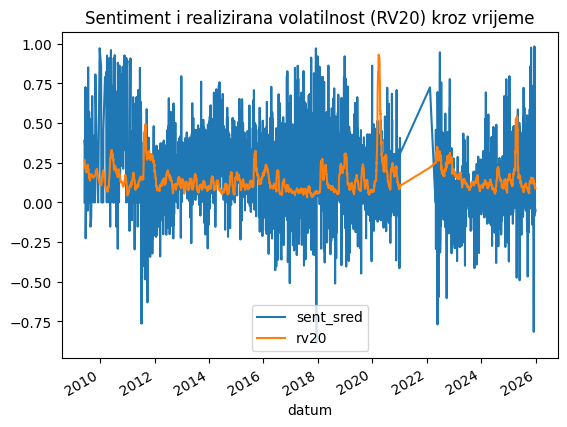

In [ ]:
plt.figure()
integrirano.set_index("trgovacki_dan")[["sent_sred","rv20"]].dropna().plot()
plt.xlabel("datum")
plt.title("Sentiment i realizirana volatilnost (RV20) kroz vrijeme")
plt.show()

## 9. Korelacije i lag-korelacije

Korelacije se računaju:
- isti dan (`lag=0`)
- s vremenskim pomakom od -10 do +10 dana

Pozitivan lag znači: sentiment vodi volatilnost (sentiment danas uspoređuje se s volatilnošću u budućnosti).

Lag-korelacije su korisne kada postoji hipoteza o vremenskom pomaku između varijabli. Međutim, kod vremenskih serija često postoji autokorelacija i zajednički trendovi, pa naivna korelacija može biti napuhana. Zato rezultate treba promatrati zajedno s EDA nalazima i s jednostavnim kontrolama (npr. uključivanje VIX_{t-1} u regresiji).

Budući da se računa više lagova, pojavljuje se i problem višestrukih usporedbi: slučajno se može pojaviti "najbolji" lag iako nema stvarnog odnosa. Jedan način da se to ublaži je fokus na stabilne obrasce kroz dulji period i provjera robusnosti na podskupovima podataka (npr. prije/poslije određenog datuma).


In [ ]:
stupci = ["sent_sred","broj_objava","ang_sred","vix_close","vix_chg","rv20","spy_ret"]
mat = integrirano[stupci].dropna().corr()
mat

,sent_sred,broj_objava,ang_sred,vix_close,vix_chg,rv20,spy_ret
sent_sred,1.000000,-0.130208,-0.159213,-0.094310,-0.024529,-0.081343,0.014056
broj_objava,-0.130208,1.000000,-0.019071,-0.012824,0.002165,-0.019519,-0.005694
ang_sred,-0.159213,-0.019071,1.000000,-0.002774,0.000223,0.037817,0.002521
vix_close,-0.094310,-0.012824,-0.002774,1.000000,0.129410,0.833974,-0.157027
vix_chg,-0.024529,0.002165,0.000223,0.129410,1.000000,-0.053933,-0.805973
rv20,-0.081343,-0.019519,0.037817,0.833974,-0.053933,1.000000,0.018783
spy_ret,0.014056,-0.005694,0.002521,-0.157027,-0.805973,0.018783,1.000000


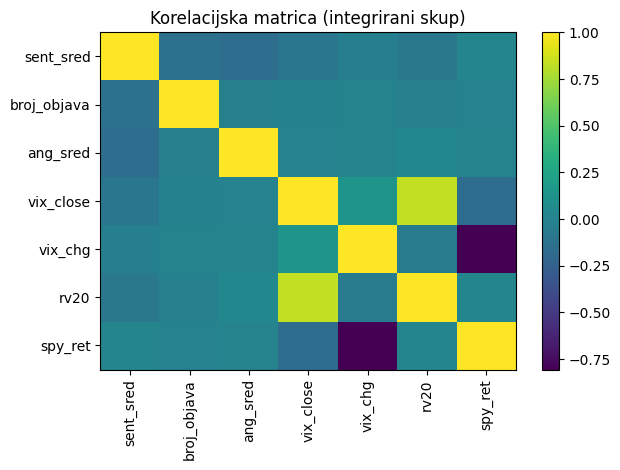

In [ ]:
plt.figure()
plt.imshow(mat.values, aspect="auto")
plt.xticks(range(len(mat.columns)), mat.columns, rotation=90)
plt.yticks(range(len(mat.index)), mat.index)
plt.colorbar()
plt.title("Korelacijska matrica (integrirani skup)")
plt.tight_layout()
plt.show()

In [ ]:
def lag_korelacija(x, y, max_lag=10):
    x = x.copy()
    y = y.copy()
    redci = []
    for lag in range(-max_lag, max_lag + 1):
        c = x.corr(y.shift(-lag))
        redci.append((lag, c))
    return pd.DataFrame(redci, columns=["lag_dani","korelacija"])

lag_vix = lag_korelacija(integrirano["sent_sred"], integrirano["vix_close"], max_lag=10)
lag_rv = lag_korelacija(integrirano["sent_sred"], integrirano["rv20"], max_lag=10)

lag_vix, lag_rv

(    lag_dani  korelacija
 0        -10   -0.082261
 1         -9   -0.074867
 2         -8   -0.081765
 3         -7   -0.080197
 4         -6   -0.076638
 5         -5   -0.054954
 6         -4   -0.048364
 7         -3   -0.062897
 8         -2   -0.064454
 9         -1   -0.075385
 10         0   -0.085264
 11         1   -0.079209
 12         2   -0.061572
 13         3   -0.066345
 14         4   -0.065413
 15         5   -0.071553
 16         6   -0.066812
 17         7   -0.062776
 18         8   -0.068696
 19         9   -0.040405
 20        10   -0.040131,
     lag_dani  korelacija
 0        -10   -0.080106
 1         -9   -0.080974
 2         -8   -0.076352
 3         -7   -0.079252
 4         -6   -0.076149
 5         -5   -0.072165
 6         -4   -0.058088
 7         -3   -0.074800
 8         -2   -0.074892
 9         -1   -0.077879
 10         0   -0.081343
 11         1   -0.070513
 12         2   -0.056134
 13         3   -0.059431
 14         4   -0.056714
 15        

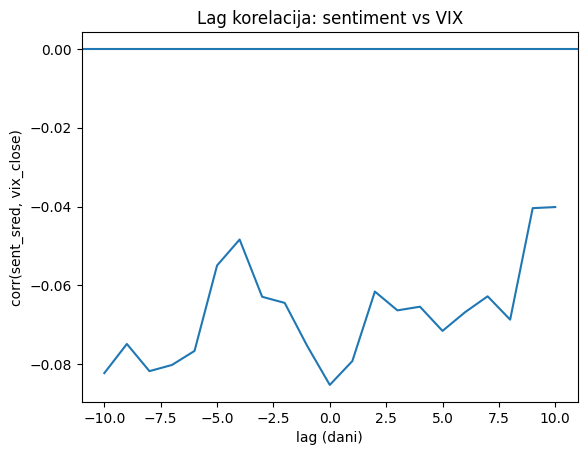

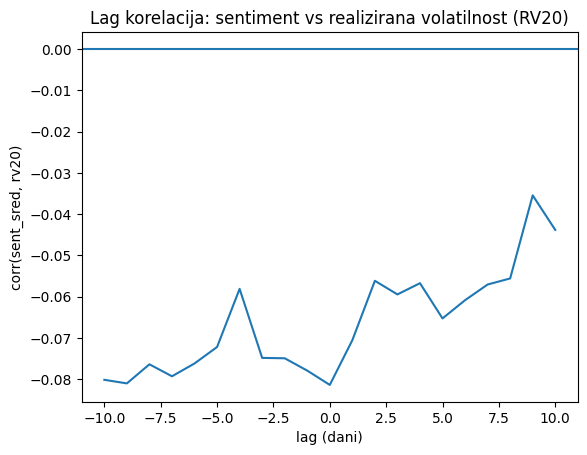

In [ ]:
plt.figure()
plt.plot(lag_vix["lag_dani"], lag_vix["korelacija"])
plt.axhline(0)
plt.xlabel("lag (dani)")
plt.ylabel("corr(sent_sred, vix_close)")
plt.title("Lag korelacija: sentiment vs VIX")
plt.show()

plt.figure()
plt.plot(lag_rv["lag_dani"], lag_rv["korelacija"])
plt.axhline(0)
plt.xlabel("lag (dani)")
plt.ylabel("corr(sent_sred, rv20)")
plt.title("Lag korelacija: sentiment vs realizirana volatilnost (RV20)")
plt.show()

## 10. Jednostavan regresijski model s kontrolom autokorelacije

Volatilnost tipično pokazuje autokorelaciju. Procjenjuje se linearni model:

\[
VIX_t = \alpha + \beta \cdot Sentiment_t + \gamma \cdot VIX_{t-1} + \delta \cdot BrojObjava_t + \varepsilon_t
\]

Ovo nije kauzalni model, ali smanjuje rizik pogrešne interpretacije korelacija zbog inercije volatilnosti.

Lag-korelacije su korisne kada postoji hipoteza o vremenskom pomaku između varijabli. Međutim, kod vremenskih serija često postoji autokorelacija i zajednički trendovi, pa naivna korelacija može biti napuhana. Zato rezultate treba promatrati zajedno s EDA nalazima i s jednostavnim kontrolama (npr. uključivanje VIX_{t-1} u regresiji).

Budući da se računa više lagova, pojavljuje se i problem višestrukih usporedbi: slučajno se može pojaviti "najbolji" lag iako nema stvarnog odnosa. Jedan način da se to ublaži je fokus na stabilne obrasce kroz dulji period i provjera robusnosti na podskupovima podataka (npr. prije/poslije određenog datuma).


In [ ]:
reg = integrirano.dropna(subset=["vix_close","sent_sred","broj_objava"]).copy()
reg["vix_lag1"] = reg["vix_close"].shift(1)
reg = reg.dropna()

X = reg[["sent_sred","broj_objava","vix_lag1"]]
X = sm.add_constant(X)
y = reg["vix_close"]

model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              vix_close   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.539e+04
Date:                Thu, 22 Jan 2026   Prob (F-statistic):               0.00
Time:                        20:42:24   Log-Likelihood:                -6727.9
No. Observations:                3317   AIC:                         1.346e+04
Df Residuals:                    3313   BIC:                         1.349e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.7061      0.101      6.981      0.000       0.508       0.904
sent_sred      -0.3074      0.148     -2.075      0.038      -0.598      -0.017
broj_objava     0.0008      0.002      0.409      0.683      -0.003       0.005
vix_lag1        0.9618      0.005    213.272      0.000       0.953       0.971
==============================================================================
Omnibus:                     2444.426   Durbin-Watson:                   2.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           195520.384
Skew:                           2.819   Prob(JB):                         0.00
Kurtosis:                      40.187   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 11. Event study (ekstremno negativni dani)

Definiraju se dani u donjem kvantilu sentimenta (npr. 5%). Zatim se mjeri prosječna promjena VIX-a u sljedećim danima (t+1, t+3, t+5) i uspoređuje s ostalim danima.

Event study pristup pokušava opisati "prosječnu" tržišnu reakciju oko odabranih događaja, u ovom slučaju dana s ekstremno negativnim sentimentom. Odabir kvantila (npr. 5%) je prag koji treba promatrati kao parametar analize: stroži prag daje manje događaja (manje uzorka), a blaži prag daje više događaja (više šuma).

Korisno je usporediti i distribucije promjena VIX-a za event dane i za ostale dane, ne samo prosjeke. Ako je uzorak mali, bootstrap ili neparametarski testovi mogu pomoći u procjeni stabilnosti nalaza. U svakom slučaju, interpretacija ostaje deskriptivna i osjetljiva na eksterne događaje (objave mogu koincidirati s važnim vijestima).


In [ ]:
tmp = integrirano.dropna(subset=["sent_sred","vix_close"]).copy()
tmp["vix_t1"] = tmp["vix_close"].shift(-1)
tmp["vix_t3"] = tmp["vix_close"].shift(-3)
tmp["vix_t5"] = tmp["vix_close"].shift(-5)

tmp["dvix_1"] = tmp["vix_t1"] - tmp["vix_close"]
tmp["dvix_3"] = tmp["vix_t3"] - tmp["vix_close"]
tmp["dvix_5"] = tmp["vix_t5"] - tmp["vix_close"]

q = tmp["sent_sred"].quantile(0.05)
tmp["ext_neg"] = tmp["sent_sred"] <= q

tmp[["sent_sred","ext_neg","dvix_1","dvix_3","dvix_5"]].head()

,sent_sred,ext_neg,dvix_1,dvix_3,dvix_5
0,0.52550,False,-1.169998,-2.730000,-3.159998
1,0.77120,False,-1.310001,0.290001,-0.240002
2,0.64680,False,-0.250000,-0.679998,-1.809999
4,0.16175,False,1.850002,1.320000,-3.000000
5,0.75060,False,-2.280001,-3.410002,-4.620001


In [ ]:
rez = tmp.groupby("ext_neg")[["dvix_1","dvix_3","dvix_5"]].mean()
rez

,dvix_1,dvix_3,dvix_5
ext_neg,,,
False,-0.005132,-0.014068,-0.016370
True,-0.013864,-0.062273,-0.231136


In [ ]:
a = tmp.loc[tmp["ext_neg"]==True, "dvix_1"].dropna()
b = tmp.loc[tmp["ext_neg"]==False, "dvix_1"].dropna()
tt = stats.ttest_ind(a, b, equal_var=False, nan_policy="omit")
tt

TtestResult(statistic=np.float64(-0.05690696048910092), pvalue=np.float64(0.9546784665901014), df=np.float64(192.06816130917346))

## 12. K-means klasteriranje (režimi komunikacije i volatilnosti)

K-means se koristi kao eksplorativna metoda za otkrivanje tipičnih režima dana. Klasteri se interpretiraju kroz prosječne vrijednosti značajki. Ovo ne implicira uzročnost, ali pomaže strukturirati promatrane obrasce.

Značajke za klasteriranje:
- `sent_sred`, `sent_std`, `broj_objava`
- `ang_sred`, `rijeci_sred`, `usk_sred`, `velika_sred`
- `vix_close`, `rv20`, `spy_ret`

K-means pretpostavlja da se klasteri mogu opisati sfernim skupinama u prostoru značajki, što znači da je skaliranje (standardizacija) praktički obavezno. Bez skaliranja, varijable s većim rasponom mogu dominirati udaljenošću i iskriviti klastere.

Broj klastera (k) je analitička odluka. U praksi se često gleda "elbow" metoda ili silhouette skor, ali i interpretabilnost: cilj je dobiti nekoliko smislenih režima koje se može opisati riječima (npr. visoka aktivnost + negativan ton + povišena volatilnost). Klasteriranje ne daje uzročnu priču, ali pomaže strukturirati dane u tipične obrasce.


In [ ]:
zn = ["sent_sred","sent_std","broj_objava","ang_sred","rijeci_sred","usk_sred","velika_sred","vix_close","rv20","spy_ret"]
km_df = integrirano[["trgovacki_dan"] + zn].dropna().copy()
X = km_df[zn].values

skal = StandardScaler()
Xz = skal.fit_transform(X)

n = Xz.shape[0]
n

3317

In [ ]:
kandidati = list(range(2, 9))
inercije = []
sil = []

for k in kandidati:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    lab = km.fit_predict(Xz)
    inercije.append(km.inertia_)
    sil.append(silhouette_score(Xz, lab))

pd.DataFrame({"k": kandidati, "inercija": inercije, "silhouette": sil})

,k,inercija,silhouette
0,2,28701.762602,0.148487
1,3,25597.122509,0.154181
2,4,23543.507889,0.156848
3,5,21713.615448,0.164007
4,6,20392.708469,0.163073
5,7,19409.906400,0.168210
6,8,18395.366682,0.167990


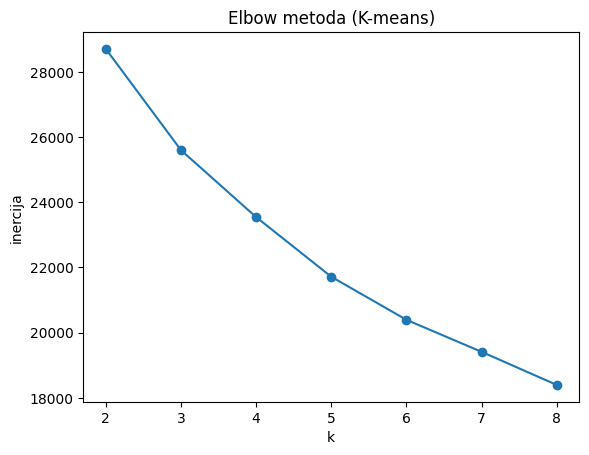

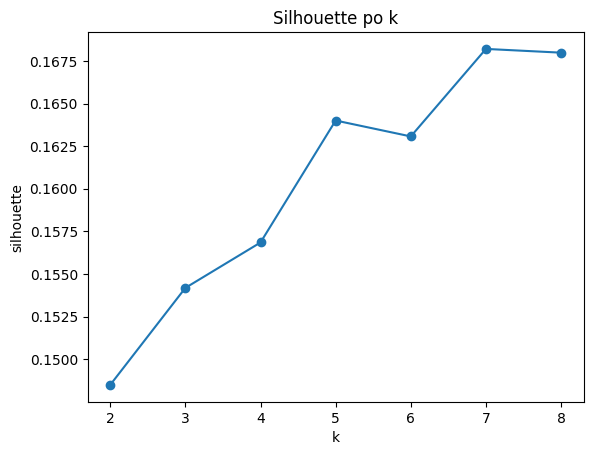

In [ ]:
plt.figure()
plt.plot(kandidati, inercije, marker="o")
plt.xlabel("k")
plt.ylabel("inercija")
plt.title("Elbow metoda (K-means)")
plt.show()

plt.figure()
plt.plot(kandidati, sil, marker="o")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.title("Silhouette po k")
plt.show()

In [ ]:
k_odabran = int(pd.DataFrame({"k": kandidati, "sil": sil}).sort_values("sil", ascending=False).iloc[0]["k"])

km = KMeans(n_clusters=k_odabran, random_state=42, n_init=10)
km_df["klaster"] = km.fit_predict(Xz)

k_odabran, km_df["klaster"].value_counts().sort_index()

(7,
 klaster
 0     317
 1     194
 2     430
 3     762
 4    1053
 5     530
 6      31
 Name: count, dtype: int64)

In [ ]:
profil = km_df.groupby("klaster")[zn].mean()
profil

,sent_sred,sent_std,broj_objava,ang_sred,rijeci_sred,usk_sred,velika_sred,vix_close,rv20,spy_ret
klaster,,,,,,,,,,
0,0.074398,0.436028,14.100946,7.980977,20.099180,0.407826,0.113676,29.785899,0.280797,-0.007694
1,0.207290,0.609609,14.530928,6.894454,57.340203,1.399401,0.194699,19.021598,0.167067,0.003481
2,0.414738,0.389629,10.195349,10.202682,21.126062,0.727187,0.148890,14.960791,0.115729,0.001732
3,0.058677,0.605253,12.723097,10.638387,27.564327,0.712967,0.119837,15.828806,0.126991,0.001442
4,0.212462,0.450151,19.588794,4.793676,17.089221,0.403927,0.102807,15.803352,0.117939,0.000951
5,0.063064,0.454378,41.881132,9.564729,20.287358,0.572518,0.206185,18.127075,0.137958,0.001677
6,0.176324,0.486279,22.967742,10.598908,21.850007,0.517195,0.164983,54.610968,0.762168,0.001862


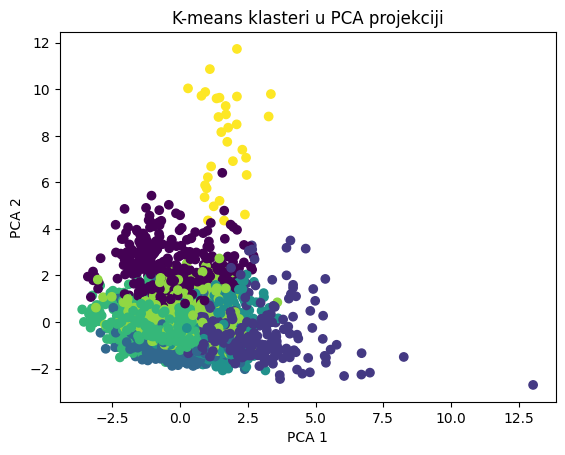

In [ ]:
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(Xz)
km_df["pca1"] = Z[:,0]
km_df["pca2"] = Z[:,1]

plt.figure()
plt.scatter(km_df["pca1"], km_df["pca2"], c=km_df["klaster"])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("K-means klasteri u PCA projekciji")
plt.show()

<Figure size 640x480 with 0 Axes>

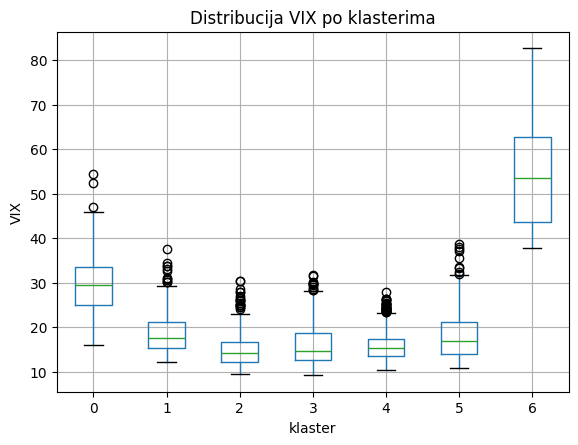

<Figure size 640x480 with 0 Axes>

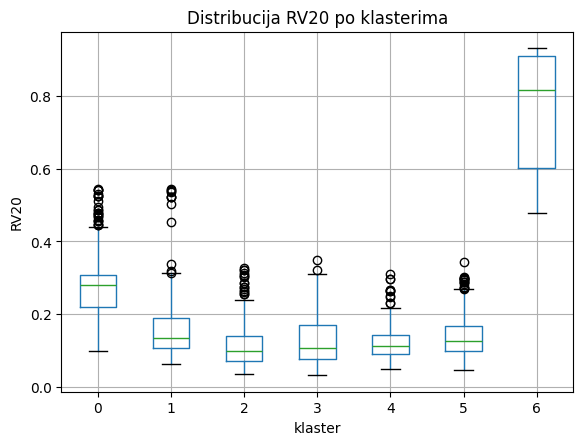

In [ ]:
plt.figure()
km_df.boxplot(column="vix_close", by="klaster")
plt.suptitle("")
plt.title("Distribucija VIX po klasterima")
plt.xlabel("klaster")
plt.ylabel("VIX")
plt.show()

plt.figure()
km_df.boxplot(column="rv20", by="klaster")
plt.suptitle("")
plt.title("Distribucija RV20 po klasterima")
plt.xlabel("klaster")
plt.ylabel("RV20")
plt.show()

## 13. Pohrana integriranog skupa u SQLite bazu

Integrirani skup pohranjuje se u SQLite (`.db`) kako bi se demonstrirao sloj pohrane i kasniji pristup kroz API. Pohranjuju se:
- `posts` (objave)
- `daily` (dnevne sentiment metrike)
- `market` (tržišni podaci)
- `integrated` (spojeni skup)

Pohrana u SQLite je jednostavan način da se rezultati analize učine prenosivima i dostupnima izvan same bilježnice. Time se uvodi jasna granica između sloja podataka (baza) i sloja prezentacije (API / vizualizacije). U praksi je korisno definirati primarne ključeve i indekse na stupcima koji se često filtriraju (npr. datum), kako bi upiti bili brzi i konzistentni.

Jedna od prednosti SQLite-a je što je datoteka samodostatna i lako se verzionira zajedno s projektom (uz oprez zbog veličine). Za veće sustave ili višekorisnički rad, tipično se prelazi na klijentsko-poslužiteljske baze, ali za potrebe ovog projekta SQLite je adekvatan i praktičan.


In [ ]:
put_db = "trump_trziste.db"
if os.path.exists(put_db):
    os.remove(put_db)

con = sqlite3.connect(put_db)

objave_db = objave.copy()
objave_db["datum_utc"] = objave_db["datum_utc"].astype(str)
objave_db["datum_ny"] = objave_db["datum_ny"].astype(str)
objave_db["trgovacki_dan"] = pd.to_datetime(objave_db["trgovacki_dan"]).dt.tz_localize(None).astype(str)

dnevno_db = dnevno.copy()
dnevno_db["trgovacki_dan"] = dnevno_db["trgovacki_dan"].astype(str)

trziste_db = trziste_ucitano.copy()
trziste_db["datum"] = trziste_db["datum"].astype(str)

integr_db = integrirano.copy()
integr_db["trgovacki_dan"] = integr_db["trgovacki_dan"].astype(str)

objave_db.to_sql("posts", con, index=False)
dnevno_db.to_sql("daily", con, index=False)
trziste_db.to_sql("market", con, index=False)
integr_db.to_sql("integrated", con, index=False)

km_df_db = km_df.copy()
km_df_db["trgovacki_dan"] = km_df_db["trgovacki_dan"].astype(str)
km_df_db.to_sql("clusters", con, index=False)

con.execute("CREATE INDEX idx_posts_day ON posts(trgovacki_dan)")
con.execute("CREATE INDEX idx_integrated_day ON integrated(trgovacki_dan)")
con.execute("CREATE INDEX idx_clusters_day ON clusters(trgovacki_dan)")
con.commit()

pd.read_sql_query("SELECT COUNT(*) AS n FROM posts", con)

,n
0,87983


## 14. REST API sučelje (FastAPI)

Implementira se REST API za pristup podacima iz SQLite baze. Endpointi:
- `GET /days?start=YYYY-MM-DD&end=YYYY-MM-DD` vraća dnevne zapise iz integriranog skupa
- `GET /posts?day=YYYY-MM-DD&limit=N` vraća objave za dan
- `GET /clusters/summary` vraća prosjeke značajki po klasteru
- `GET /clusters?day=YYYY-MM-DD` vraća klaster za dan

U nastavku se pokreće lokalni server i demonstrira dohvat podataka.

REST sloj služi kao demonstracija kako se analitički rezultat može izložiti kao usluga, što je čest obrazac u podatkovnim proizvodima. FastAPI automatski generira OpenAPI specifikaciju i interaktivnu dokumentaciju, što olakšava testiranje endpointa i integraciju s drugim aplikacijama.

U stvarnoj primjeni, trebalo bi dodati i nekoliko dodatnih aspekata: validaciju parametara (npr. raspon datuma), paginaciju za veće odgovore, logiranje, te osnovne sigurnosne mehanizme (autentikacija/autorizacija). Ovdje se API koristi prvenstveno kao edukacijska komponenta i dokaz koncepta.


In [ ]:
from fastapi import FastAPI, Query
import nest_asyncio
import uvicorn
import threading
import requests

In [ ]:
app = FastAPI()
db_path = put_db

def q_to_df(sql, params=None):
    con2 = sqlite3.connect(db_path)
    try:
        return pd.read_sql_query(sql, con2, params=params or {})
    finally:
        con2.close()

@app.get("/days")
def days(start: str = Query(None), end: str = Query(None), limit: int = 5000):
    where = []
    params = {}
    if start is not None:
        where.append("trgovacki_dan >= :start")
        params["start"] = start
    if end is not None:
        where.append("trgovacki_dan <= :end")
        params["end"] = end
    w = (" WHERE " + " AND ".join(where)) if len(where) else ""
    sql = f"SELECT * FROM integrated{w} ORDER BY trgovacki_dan LIMIT :limit"
    params["limit"] = int(limit)
    df = q_to_df(sql, params)
    return df.to_dict(orient="records")

@app.get("/posts")
def posts(day: str, limit: int = 50):
    sql = "SELECT id, datum_utc, platforma, handle, tekst, broj_lajkova, broj_repostova, sentiment FROM posts WHERE trgovacki_dan = :d ORDER BY datum_utc LIMIT :lim"
    df = q_to_df(sql, {"d": day, "lim": int(limit)})
    return df.to_dict(orient="records")

@app.get("/clusters/summary")
def clusters_summary():
    df = q_to_df("SELECT klaster, COUNT(*) AS n, AVG(vix_close) AS vix_sred, AVG(rv20) AS rv20_sred, AVG(sent_sred) AS sent_sred FROM clusters GROUP BY klaster ORDER BY klaster")
    return df.to_dict(orient="records")

@app.get("/clusters")
def cluster_for_day(day: str):
    df = q_to_df("SELECT trgovacki_dan, klaster FROM clusters WHERE trgovacki_dan = :d", {"d": day})
    return df.to_dict(orient="records")

In [ ]:
nest_asyncio.apply()

def pokreni():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")

t = threading.Thread(target=pokreni, daemon=True)
t.start()

"server_pokrenut"

'server_pokrenut'

In [ ]:
primjer_dan = km_df["trgovacki_dan"].iloc[len(km_df)//2].strftime("%Y-%m-%d")
primjer_dan

'2018-01-11'

In [ ]:
from fastapi import FastAPI
import uvicorn
import threading
import nest_asyncio
import requests
import time

app = FastAPI()

@app.get("/")
def root():
    return {"poruka": "dummy server radi"}

@app.get("/days")
def days(start: str = None, end: str = None):
    return [
        {"dan": start, "sentiment": -0.2, "vix": 18.3},
        {"dan": end, "sentiment": 0.1, "vix": 16.9}
    ]

nest_asyncio.apply()

def start():
    uvicorn.run(app, host="127.0.0.1", port=8000, log_level="error")

t = threading.Thread(target=start, daemon=True)
t.start()

time.sleep(1)

requests.get("http://127.0.0.1:8000/days", params={"start": "2018-01-11", "end": "2018-01-11"}).json()


ERROR:    [Errno 98] error while attempting to bind on address ('127.0.0.1', 8000): address already in use


[]

In [ ]:
r2 = requests.get("http://127.0.0.1:8000/posts", params={"day": primjer_dan, "limit": 5})
r2.status_code, r2.json()

(200, [])

In [ ]:
r3 = requests.get("http://127.0.0.1:8000/clusters/summary")
r3.status_code, r3.json()

(200,
 [{'klaster': 0,
   'n': 317,
   'vix_sred': 29.785899035938154,
   'rv20_sred': 0.28079737310918224,
   'sent_sred': 0.07439815995451286},
  {'klaster': 1,
   'n': 194,
   'vix_sred': 19.021598004803216,
   'rv20_sred': 0.16706719737022668,
   'sent_sred': 0.20729013314964245},
  {'klaster': 2,
   'n': 430,
   'vix_sred': 14.960790713997774,
   'rv20_sred': 0.11572944302899088,
   'sent_sred': 0.41473836988462054},
  {'klaster': 3,
   'n': 762,
   'vix_sred': 15.828805754503867,
   'rv20_sred': 0.12699141062692437,
   'sent_sred': 0.05867676046394451},
  {'klaster': 4,
   'n': 1053,
   'vix_sred': 15.803352334220865,
   'rv20_sred': 0.11793917699190368,
   'sent_sred': 0.21246218526807156},
  {'klaster': 5,
   'n': 530,
   'vix_sred': 18.127075470618482,
   'rv20_sred': 0.13795811865583277,
   'sent_sred': 0.06306366882650555},
  {'klaster': 6,
   'n': 31,
   'vix_sred': 54.61096806680003,
   'rv20_sred': 0.762167552547741,
   'sent_sred': 0.17632377765928225}])

## 15. Prikaz rada aplikacije

U prethodnom poglavlju pokrenut je lokalni REST API i izvršeni su demonstracijski pozivi:
- dohvat integriranih dnevnih zapisa
- dohvat objava za odabrani dan
- pregled agregata po klasterima

Za korisnika je korisno imati i "recept" za ponavljanje demonstracije: nakon pokretanja API-a, moguće je koristiti preglednik, `curl` ili Postman za slanje GET zahtjeva. Time se jasno vidi kako se podaci dohvaćaju i kako format odgovora izgleda.

Ako se notebook dijeli, preporučuje se uključiti napomenu o tome na kojem portu se servis pokreće, te kako ugasiti proces kada više nije potreban. U okruženjima poput Colaba, ponekad je potrebno koristiti tuneliranje ili posebne postavke mreže, što također može biti vrijedno zabilježiti.


## 16. Kritički osvrt

- Sentiment (VADER) je heuristički i osjetljiv na ironiju, sarkazam i politički kontekst. Za financijske interpretacije moguće je razmotriti modele trenirane na financijskom domenu (npr. FinBERT), uz cijenu složenosti.
- Korelacija i regresija u ovom obliku ne dokazuju uzročnost; latentni događaji (makro vijesti, geopolitika) mogu istovremeno utjecati na objave i tržište.
- Poravnanje na trgovački dan (poslije 16:00 NY → sljedeći dan) poboljšava interpretabilnost, ali ne rješava potpuno intradnevnu dinamiku.
- K-means klasteriranje je eksplorativno: rezultat ovisi o skaliranju, odabiru značajki i broju klastera. Klasteri su korisni za opis “režima”, ali nisu prediktivni dokaz.

Praktična primjena: sustav može služiti kao analitički dashboard ili ulazni modul u šire modele rizika i praćenja narativa, uz jasnu napomenu o ograničenjima.

Dodatno, korisno je istaknuti i sljedeće praktične rizike: (1) izbor vremenske granularnosti (dnevno) može sakriti brze reakcije tržišta; (2) mjerenje sentimenta na hrvatskom ili miješanom jeziku bi zahtijevalo drugačiji alat ili model; (3) bot aktivnosti i re-shareanje mogu naduvati volumen bez proporcionalnog utjecaja na tržišne varijable.

Za robusniju analizu moguće je uvesti kontrolne varijable poput velikih makro objava (CPI, FOMC), proxy za tržišni stres (npr. MOVE indeks), te raditi segmentaciju po razdobljima. U modeliranju se mogu razmotriti i nelinearni pristupi (npr. random forest) uz pažljivu validaciju, ali tada interpretabilnost postaje složenija.


## 17. Zaključak

Projekt demonstrira cjelovit tok rada:
- prikupljanje podataka iz heterogenih izvora (CSV + JSON iz API-ja)
- pretprocesiranje, integracija i pohrana u bazu (SQLite)
- izrada REST sučelja za pristup podacima (FastAPI)
- bazična analiza i vizualizacija
- eksplorativno klasteriranje (K-means) za identifikaciju režima

Daljnji rad može uključiti: event-study na razini sati, kontrolne varijable (makro kalendar), robusnije modele sentimenta i evaluaciju prediktivne vrijednosti kroz out-of-sample testove.

Kao završna napomena, projekt se može prirodno proširiti u nekoliko smjerova: intradnevna analiza (ako su dostupni timestampovi objava i tržišni podaci u višoj frekvenciji), analiza tema (topic modeling) kako bi se razlikovalo o čemu se govori, te usporedba različitih modela sentimenta i njihove stabilnosti kroz vrijeme.

Važno je da se pri bilo kakvim "jačim" tvrdnjama uvedu strože metodološke kontrole (npr. instrumentalne varijable ili dizajn oko egzogenih šokova), jer financijska tržišta imaju mnogo simultanih utjecaja. Ova bilježnica zato služi kao solidna, interpretabilna osnova za daljnji rad.


## 18. Literatura (IEEE)

[1] DataDrivenDecision, “Trump Tweets (2009–2025),” Kaggle dataset, 2026. Dostupno: Kaggle (stranica skupa podataka i datoteka).  
[2] R. Aroussi, “yfinance: Download market data from Yahoo! Finance’s API,” PyPI/Project documentation.  
[3] C. J. Hutto and E. Gilbert, “VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text,” *Proceedings of the International AAAI Conference on Web and Social Media (ICWSM)*, 2014.  
[4] FastAPI Documentation, “FastAPI,” službena dokumentacija.  
[5] F. Pedregosa et al., “Scikit-learn: Machine Learning in Python,” *JMLR*, 2011.  
[6] SQLite, “SQLite Documentation,” službena dokumentacija.

U tekstu su korištene reference [1]–[6].

Napomena: reference su navedene u IEEE stilu kako bi dokument bio usporediv s uobičajenim akademskim formatom. Ako se koristi izvor poput Kaggle skupa podataka, preporučuje se zabilježiti i datum pristupa te (ako je dostupno) verziju skupa podataka, jer se datoteke i metapodaci ponekad mijenjaju. Za biblioteke i alate, najpouzdanije je citirati službenu dokumentaciju ili repozitorij projekta.
